In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
#import tensorflow.keras.optimizers
import tensorflow.compat.v1
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from datetime import datetime

# Read your CSV file
df = pd.read_csv('./smart_grid_stability_augmented.csv')

# Drop rows with missing values
df.dropna(inplace=True)

# Filter out infinity values only from numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
for column in numeric_columns:
    is_infinite = np.isinf(df[column])
    df = df[~is_infinite]

# Remove columns with all 0 values
zero_columns = df.columns[(df == 0).all()]
df = df.drop(columns=zero_columns)

print('The dataset contains', df.shape[0], 'rows and', df.shape[1], 'columns')
df.head()

2024-05-01 04:29:09.920745: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 04:29:09.920815: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 04:29:09.920860: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-01 04:29:09.931215: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-01 04:29:11.316910: W tensorflow/compiler/

The dataset contains 60000 rows and 14 columns


,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,marker
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,Attack
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,Natural
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,Attack
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,Attack
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,Attack


In [2]:
print(df.columns)



Index(['tau1', 'tau2', 'tau3', 'tau4', 'p1', 'p2', 'p3', 'p4', 'g1', 'g2',
       'g3', 'g4', 'stab', 'marker'],
      dtype='object')


In [3]:


df.marker.unique() # Lets the program know how accurate it is



array(['Attack', 'Natural'], dtype=object)

In [4]:
# Use one-hot encoding to convert the 'marker' column
df_encoded = pd.get_dummies(df, columns=['marker'], drop_first=True) 

# Check the column names after encoding
print(df_encoded.columns)

# Calculate the correlation matrix
corr_matrix = df_encoded.corr()
corr_matrix



Index(['tau1', 'tau2', 'tau3', 'tau4', 'p1', 'p2', 'p3', 'p4', 'g1', 'g2',
       'g3', 'g4', 'stab', 'marker_Natural'],
      dtype='object')


,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,marker_Natural
tau1,1.000000,-0.002550,-0.002550,-0.002550,0.027183,-0.015739,-0.015739,-0.015739,0.010521,0.006522,0.006522,0.006522,0.275761,-0.234898
tau2,-0.002550,1.000000,0.005554,0.005554,0.003004,-0.004473,-0.000372,-0.000372,-0.005832,0.009865,0.002102,0.002102,0.283417,-0.241049
tau3,-0.002550,0.005554,1.000000,0.005554,0.003004,-0.000372,-0.004473,-0.000372,-0.005832,0.002102,0.009865,0.002102,0.283417,-0.241049
tau4,-0.002550,0.005554,0.005554,1.000000,0.003004,-0.000372,-0.000372,-0.004473,-0.005832,0.002102,0.002102,0.009865,0.283417,-0.241049
p1,0.027183,0.003004,0.003004,0.003004,1.000000,-0.578983,-0.578983,-0.578983,0.000721,0.000341,0.000341,0.000341,0.010278,-0.009938
p2,-0.015739,-0.004473,-0.000372,-0.000372,-0.578983,1.000000,0.002833,0.002833,-0.000417,-0.002141,0.000774,0.000774,-0.005951,0.005754
p3,-0.015739,-0.000372,-0.004473,-0.000372,-0.578983,0.002833,1.000000,0.002833,-0.000417,0.000774,-0.002141,0.000774,-0.005951,0.005754
p4,-0.015739,-0.000372,-0.000372,-0.004473,-0.578983,0.002833,0.002833,1.000000,-0.000417,0.000774,0.000774,-0.002141,-0.005951,0.005754
g1,0.010521,-0.005832,-0.005832,-0.005832,0.000721,-0.000417,-0.000417,-0.000417,1.000000,0.004718,0.004718,0.004718,0.282774,-0.197664
g2,0.006522,0.009865,0.002102,0.002102,0.000341,-0.002141,0.000774,0.000774,0.004718,1.000000,-0.006939,-0.006939,0.293684,-0.218015


In [5]:
# Column to keep regardless of threshold
column_to_keep = 'marker_Natural'

# Create a set to store the columns to remove
columns_to_remove = set()

# Define the correlation threshold
correlation_threshold = 0.7  # Adjust this threshold as needed (0.85)

# Iterate through the columns and find pairs with correlations above or below the threshold
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        correlation_value = corr_matrix.iloc[i, j]
        if abs(correlation_value) >= correlation_threshold:  
            col_i = corr_matrix.columns[i]
            col_j = corr_matrix.columns[j]

            # Choose one column to remove (you can customize this logic)
            # For example, you can choose the column with the shorter name
            if len(col_i) <= len(col_j):
                if (column_to_keep != col_j):
                    columns_to_remove.add(col_j)
            else:
                if (column_to_keep != col_i):
                    columns_to_remove.add(col_i)

# Remove the identified columns
df_encoded_filtered = df_encoded.drop(columns=columns_to_remove)

In [6]:
def correlation_map(f_data, f_feature, f_number):
    """
    Develops and displays a heatmap plot referenced to a primary feature of a dataframe, highlighting
    the correlation among the 'n' mostly correlated features of the dataframe.
    
    Keyword arguments:
    
    f_data      Tensor containing all relevant features, including the primary.
                Pandas dataframe
    f_feature   The primary feature.
                String
    f_number    The number of features most correlated to the primary feature.
                Integer
    """
    f_most_correlated = f_data.corr().nlargest(f_number,f_feature)[f_feature].index
    f_correlation = f_data[f_most_correlated].corr()
    
    f_mask = np.zeros_like(f_correlation)
    f_mask[np.triu_indices_from(f_mask)] = True
    with sns.axes_style("white"): 
        f_fig, f_ax = plt.subplots(figsize=(12, 12))
        sns.heatmap(f_correlation, mask=f_mask, vmin=-1, vmax=1, square=True,
                    center=0, annot=False, annot_kws={"size": 8}, cmap="PRGn")
    plt.show()



In [7]:
print(df_encoded_filtered.columns)

Index(['tau1', 'tau2', 'tau3', 'tau4', 'p1', 'p2', 'p3', 'p4', 'g1', 'g2',
       'g3', 'g4', 'stab', 'marker_Natural'],
      dtype='object')


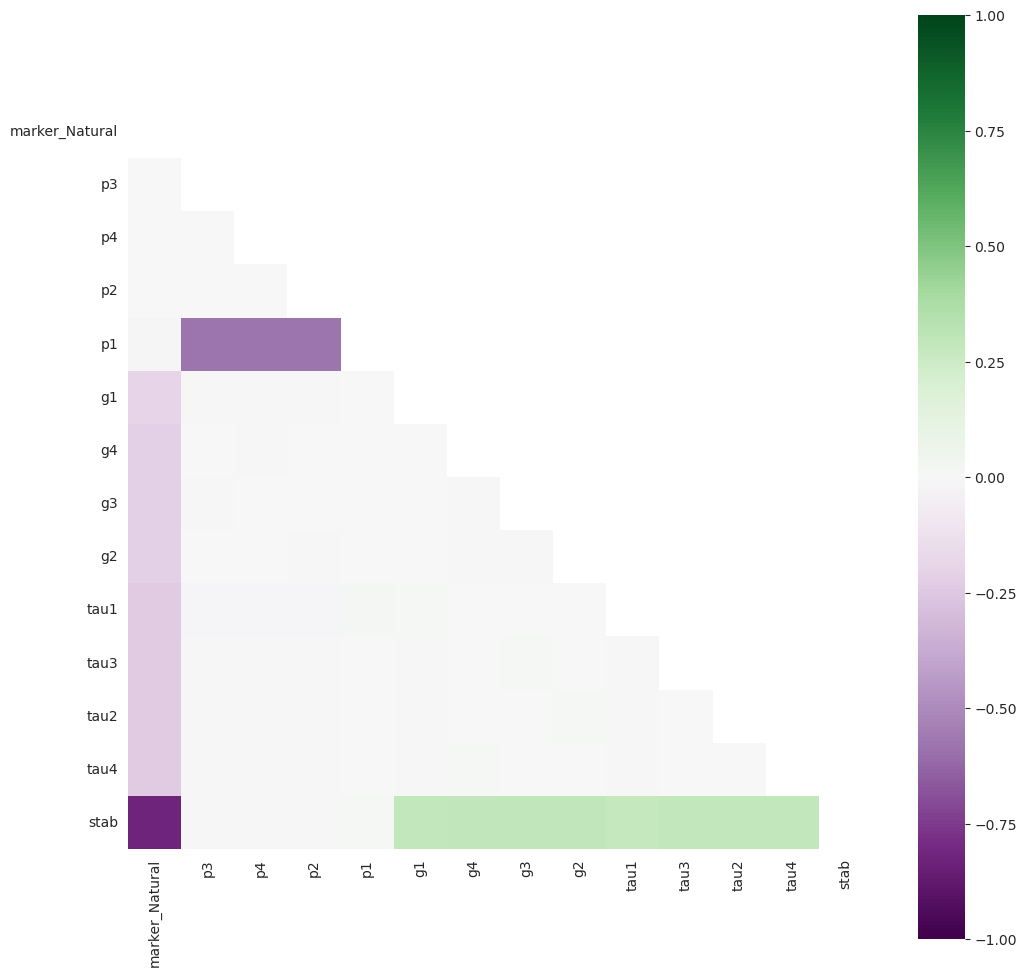

In [8]:
# Select 'marker_Natural' as the primary feature
correlation_map(df_encoded_filtered, 'marker_Natural', 37)



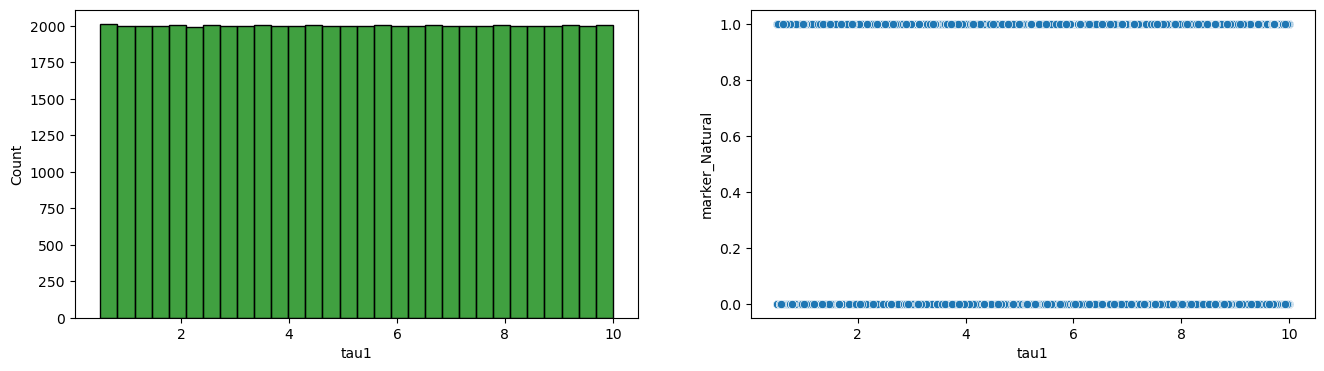

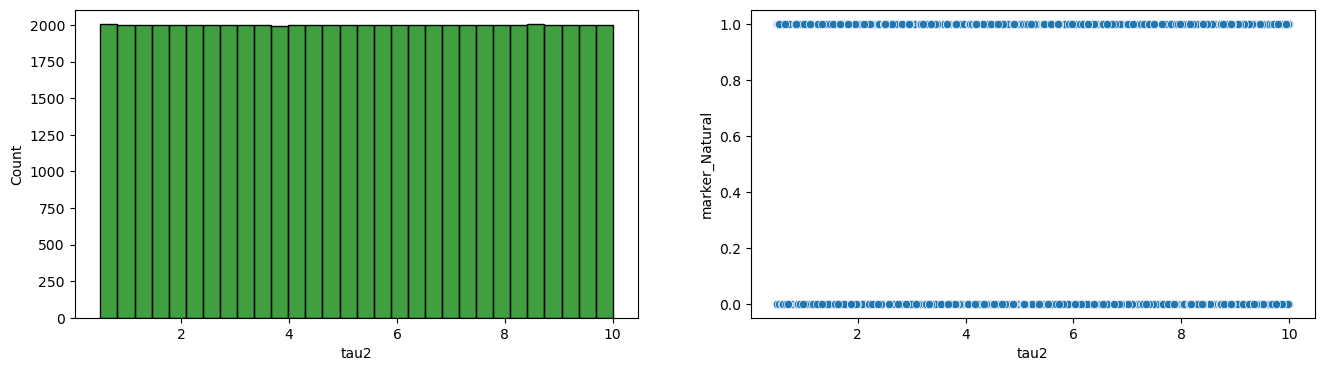

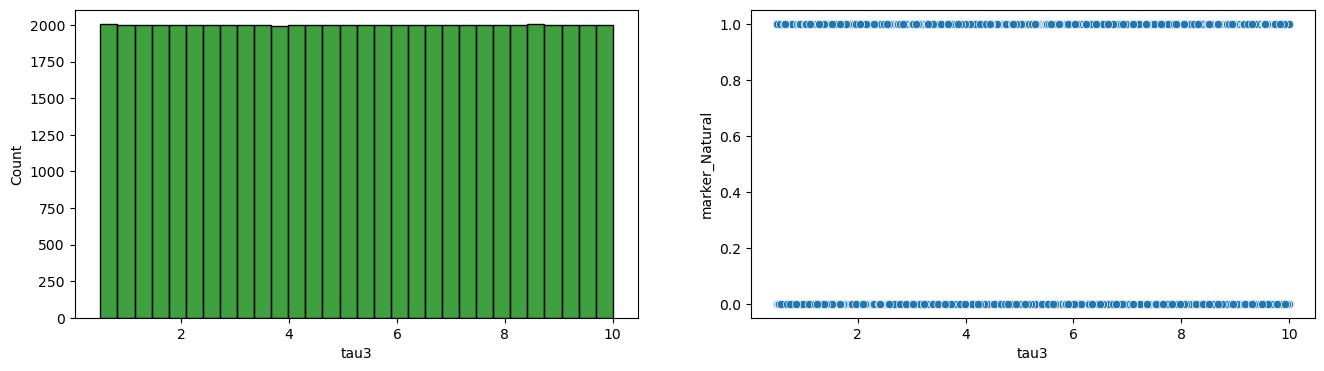

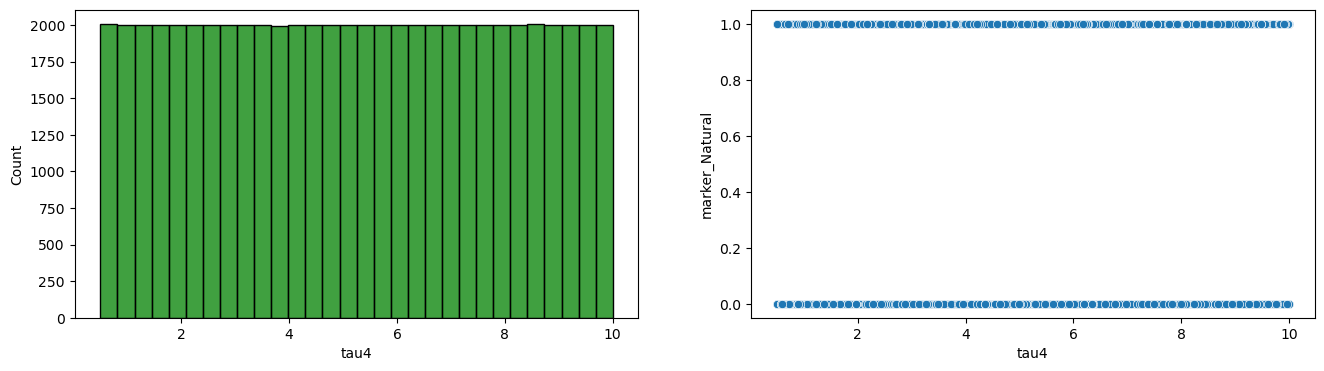

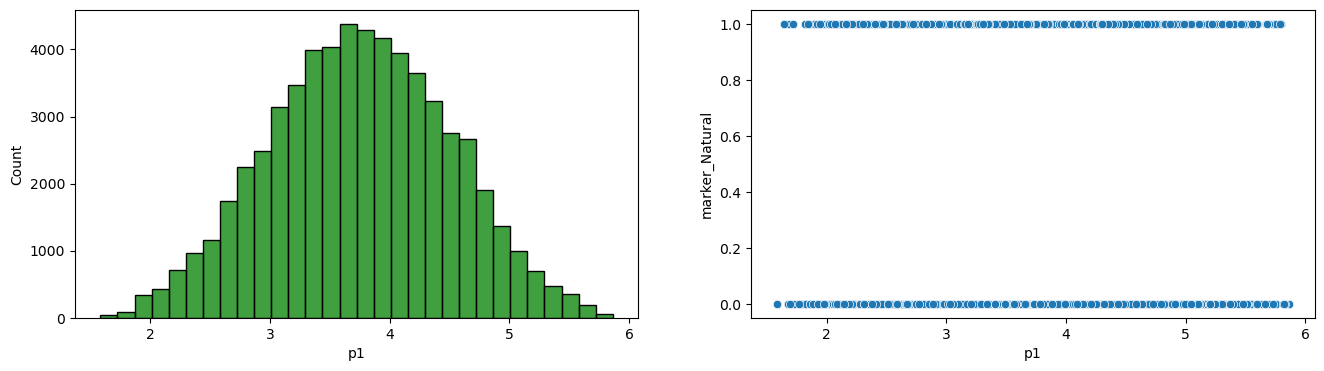

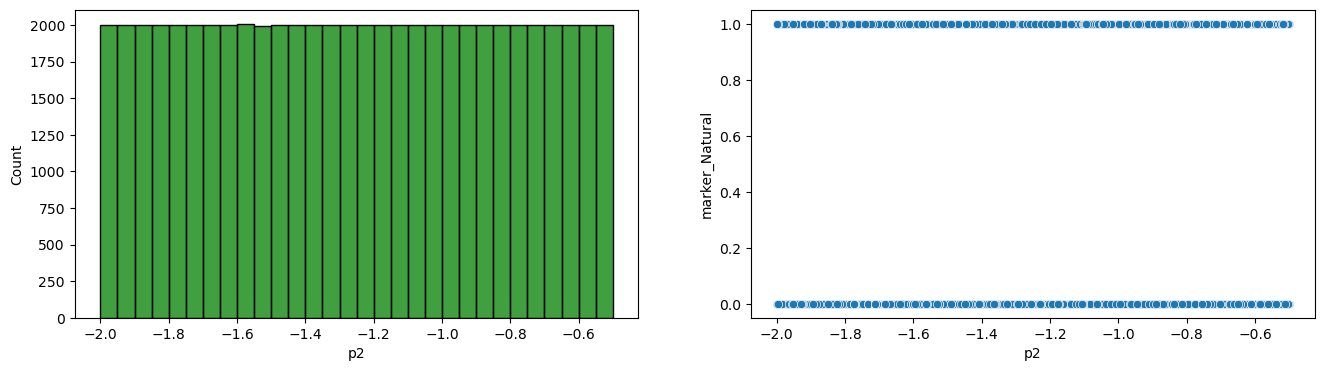

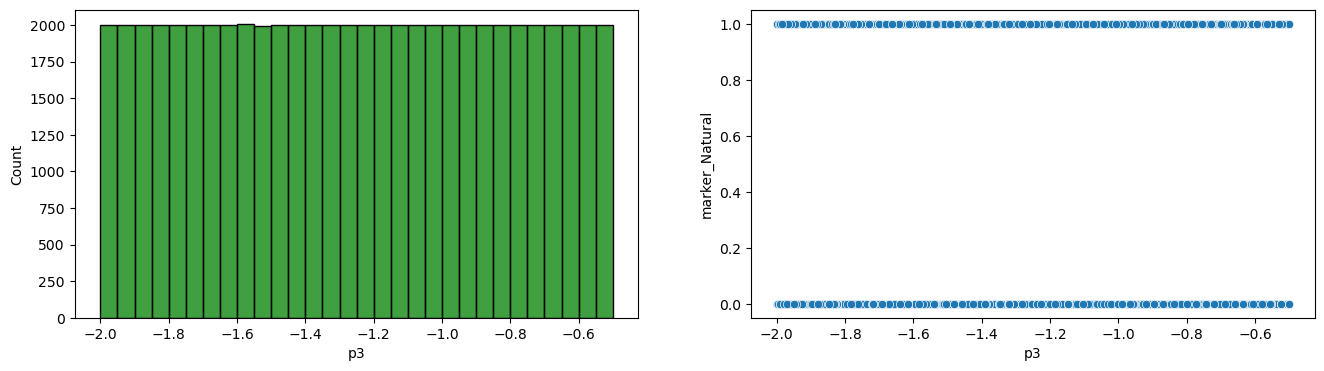

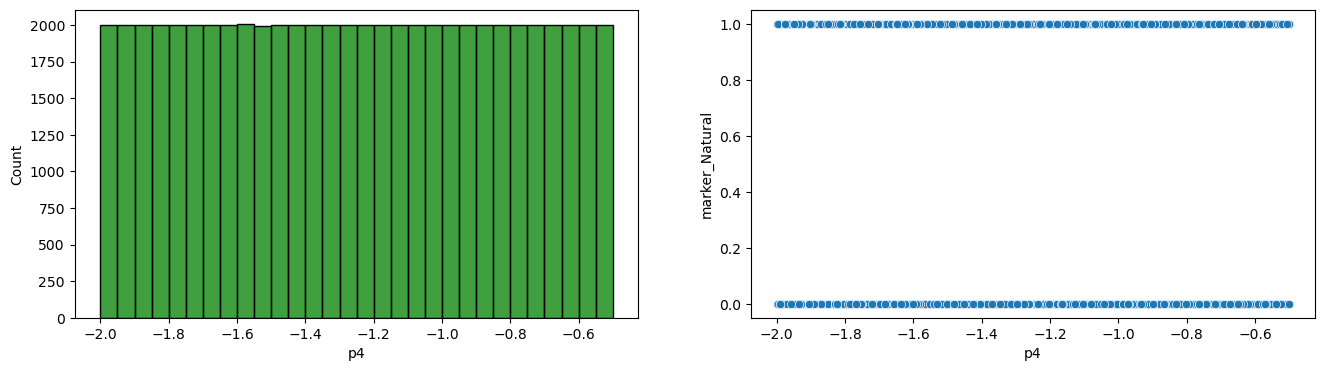

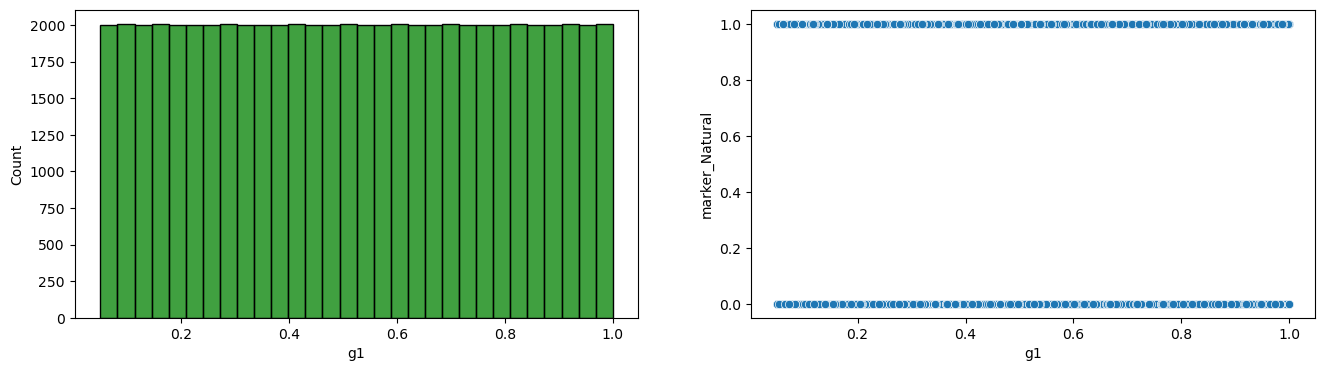

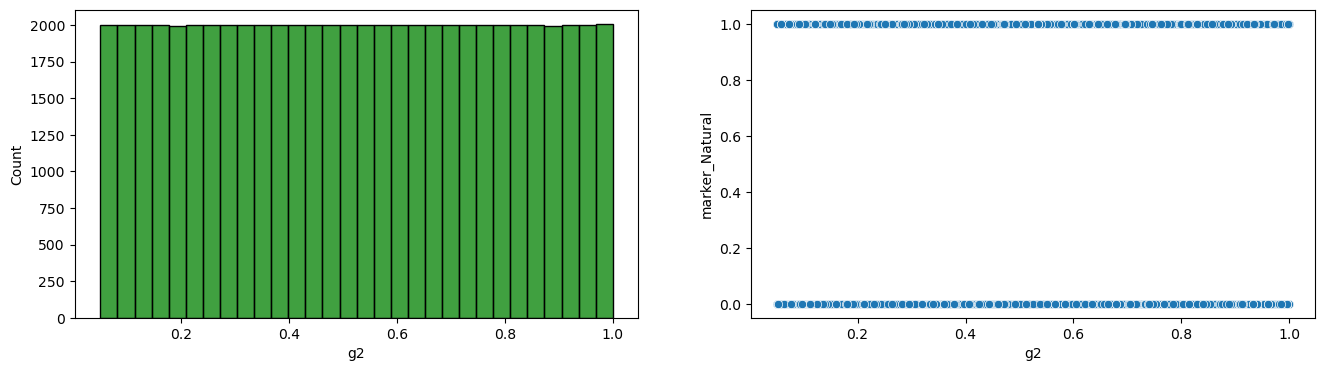

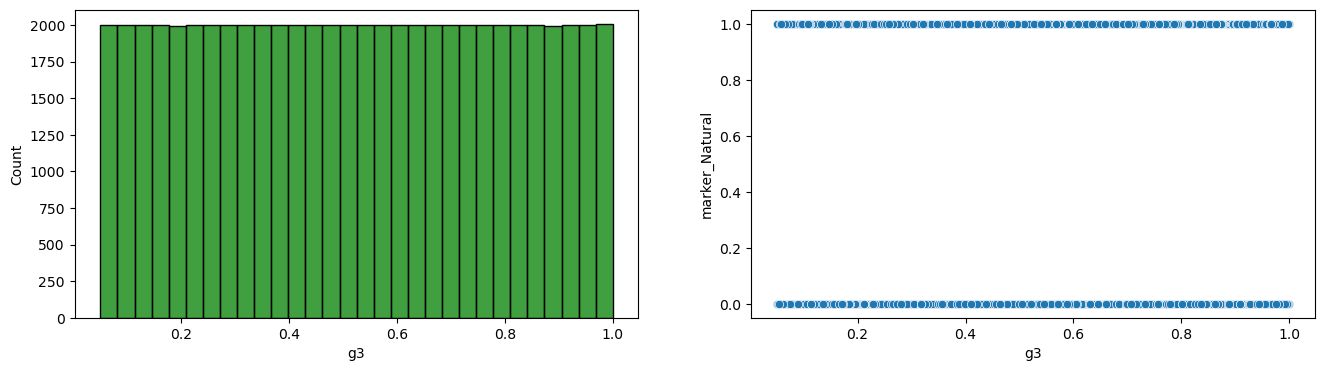

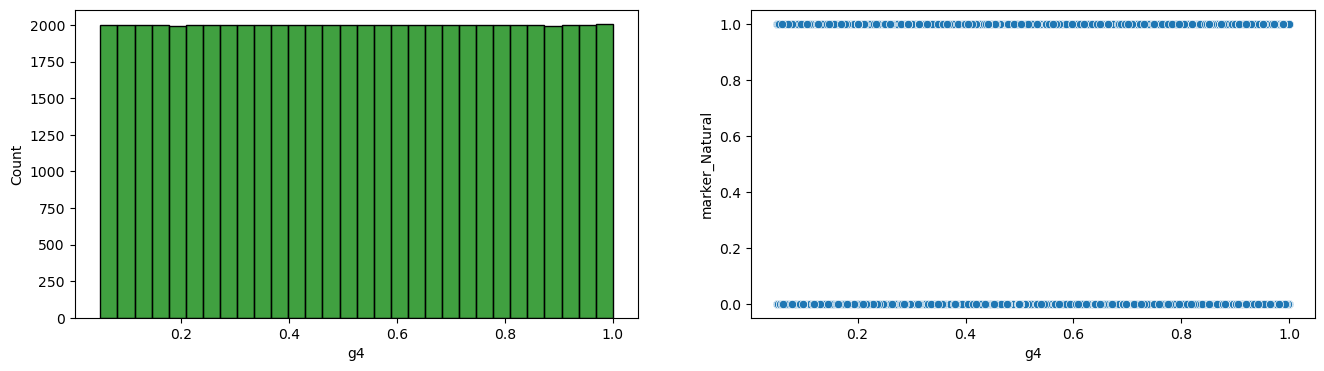

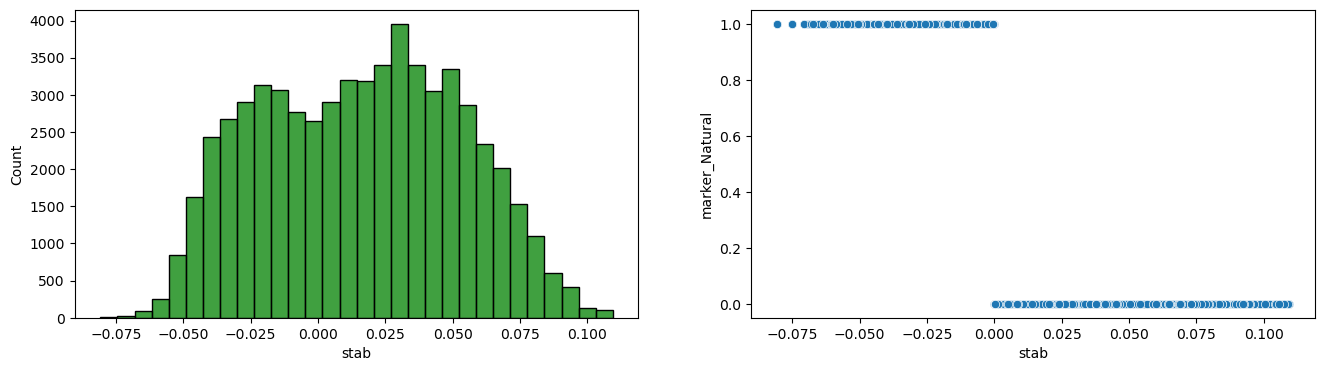

In [9]:
#import pandas as pd
#import numpy as np
#import matplotlib.pyplot as plt
#import seaborn as sns

# Define the assessment function
def assessment(f_data, f_y_feature, f_x_feature, f_index=-1):
    """
    Develops and displays a histogram and a scatter plot for a dependent / independent variable pair from
    a dataframe and, optionally, highlights a specific observation on the plot in a different color (red).
    
    Also optionally, if an independent feature is not informed, the scatterplot is not displayed.
    
    Keyword arguments:
    
    f_data      DataFrame containing the dependent / independent variable pair.
                Pandas DataFrame
    f_y_feature Dependent variable designation (e.g., 'marker_Attack').
                String
    f_x_feature Independent variable designation (e.g., column name).
                String
    f_index     If greater or equal to zero, the observation denoted by f_index will be plotted in red.
                Integer
    """
    # Determine the color for plotting
    if f_index >= 0:
        f_color = np.where(f_data.index == f_index, 'r', 'g')
        f_hue = None
    else:
        f_color = 'b'
        f_hue = None
    
    # Create subplots for histogram and scatter plot
    f_fig, f_a = plt.subplots(1, 2, figsize=(16, 4))
    
    # Plot histogram using sns.histplot with a fixed number of bins
    f_chart1 = sns.histplot(f_data[f_x_feature], ax=f_a[0], bins=30, color='g')
    f_chart1.set_xlabel(f_x_feature, fontsize=10)
    
    # Plot scatter plot (if independent feature is provided)
    if f_index >= 0:
        f_chart2 = plt.scatter(f_data[f_x_feature], f_data[f_y_feature], c=f_color, edgecolors='w')
        f_chart2 = plt.xlabel(f_x_feature, fontsize=10)
        f_chart2 = plt.ylabel(f_y_feature, fontsize=10)
    else:
        f_chart2 = sns.scatterplot(x=f_x_feature, y=f_y_feature, data=f_data, hue=f_hue, legend=False)
        f_chart2.set_xlabel(f_x_feature, fontsize=10)
        f_chart2.set_ylabel(f_y_feature, fontsize=10)

    plt.show()

# Assess relationships for 'marker_Natural' and other columns in df_encoded_filtered
for column in df_encoded_filtered.columns:
    if column != 'marker_Natural':  # Skip the dependent variable itself
        assessment(df_encoded_filtered, 'marker_Natural', column, -1)

In [10]:
df_encoded_filtered.shape



(60000, 14)

In [11]:
lengthCol = len(df_encoded_filtered.columns)



In [12]:
X = df_encoded_filtered.iloc[:, :(lengthCol-2)] # Note: two less than df_encoded_filtered.shape column
y = df_encoded_filtered.iloc[:, (lengthCol-1)] # Note: one less than df_encoded_filtered.shape column
y



0        False
1         True
2        False
3        False
4        False
         ...  
59995    False
59996     True
59997     True
59998    False
59999    False
Name: marker_Natural, Length: 60000, dtype: bool

In [13]:
X_training = X.iloc[:3500, :]
y_training = y.iloc[:3500]

X_testing = X.iloc[3500:, :]
y_testing = y.iloc[3500:]

ratio_training = y_training.value_counts(normalize=True)
ratio_testing = y_testing.value_counts(normalize=True)
ratio_training, ratio_testing

(marker_Natural
 False    0.630571
 True     0.369429
 Name: proportion, dtype: float64,
 marker_Natural
 False    0.63846
 True     0.36154
 Name: proportion, dtype: float64)

In [14]:
X_training = X_training.values
y_training = y_training.values

X_testing = X_testing.values
y_testing = y_testing.values

X_testing



array([[7.59222336, 1.38950867, 7.28589559, ..., 0.46955836, 0.55976862,
        0.17052871],
       [9.20373904, 3.03113388, 2.74208849, ..., 0.94559662, 0.78677614,
        0.52785195],
       [4.01600415, 8.50112731, 5.34537329, ..., 0.30035604, 0.25177486,
        0.55997596],
       ...,
       [2.36403419, 8.77639096, 2.84203025, ..., 0.14928646, 0.98650532,
        0.14598403],
       [9.63151069, 2.75707093, 3.9943976 , ..., 0.88911835, 0.58755755,
        0.81839133],
       [6.53052662, 4.34969522, 6.7817899 , ..., 0.37876093, 0.50544105,
        0.94263083]])

In [15]:


y_testing



array([False, False, False, ...,  True, False, False])

In [16]:
scaler = StandardScaler()
X_training = scaler.fit_transform(X_training)
X_testing = scaler.transform(X_testing)



In [17]:
!pip install keras
!pip install tensorflow==2.14.1


In [18]:
from keras.models import Sequential
from keras.layers import Dense, Input

# Initialize the classifier as a Sequential model
classifier = Sequential()

# Define the input shape explicitly using an Input layer
classifier.add(Input(shape=(lengthCol-2,)))

# First hidden layer
classifier.add(Dense(units=lengthCol-2, kernel_initializer='uniform', activation='relu'))

# Second hidden layer
classifier.add(Dense(units=lengthCol-2, kernel_initializer='uniform', activation='sigmoid'))

# Third hidden layer (seems to serve the same role as the second)
classifier.add(Dense(units=lengthCol-2, kernel_initializer='uniform', activation='sigmoid'))

# Output layer with a single node (for binary classification)
classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

# Compile the ANN
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])




2024-05-01 04:29:30.728779: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [19]:
cross_val_round = 1
print(f'Model evaluation\n')

for train_index, val_index in KFold(20, shuffle=True, random_state=10).split(X_training):
    x_train, x_val = X_training[train_index], X_training[val_index]
    y_train ,y_val = y_training[train_index], y_training[val_index]
    # (Epochs): used to separate training into distinct phases, which is useful for logging and periodic evaluation.
    # Therefore, the more epochs, the more the model is trained.
    classifier.fit(x_train, y_train, epochs=25, verbose=0)
    classifier_loss, classifier_accuracy = classifier.evaluate(x_val, y_val)
    print(f'Round {cross_val_round} - Loss: {classifier_loss:.4f} | Accuracy: {classifier_accuracy * 100:.2f} %')
    cross_val_round += 1



Model evaluation

6/6 [==============================] - 0s 2ms/step - loss: 0.4986 - accuracy: 0.7886
Round 1 - Loss: 0.4986 | Accuracy: 78.86 %
6/6 [==============================] - 0s 2ms/step - loss: 0.3687 - accuracy: 0.8229
Round 2 - Loss: 0.3687 | Accuracy: 82.29 %
6/6 [==============================] - 0s 2ms/step - loss: 0.3668 - accuracy: 0.8400
Round 3 - Loss: 0.3668 | Accuracy: 84.00 %
6/6 [==============================] - 0s 2ms/step - loss: 0.3410 - accuracy: 0.8457
Round 4 - Loss: 0.3410 | Accuracy: 84.57 %
6/6 [==============================] - 0s 2ms/step - loss: 0.3050 - accuracy: 0.8514
Round 5 - Loss: 0.3050 | Accuracy: 85.14 %
6/6 [==============================] - 0s 2ms/step - loss: 0.2557 - accuracy: 0.8914
Round 6 - Loss: 0.2557 | Accuracy: 89.14 %
6/6 [==============================] - 0s 2ms/step - loss: 0.2673 - accuracy: 0.8914
Round 7 - Loss: 0.2673 | Accuracy: 89.14 %
6/6 [==============================] - 0s 2ms/step - loss: 0.3728 - accuracy: 0.8343
R

In [20]:
y_pred = classifier.predict(X_testing)
y_pred



1766/1766 [==============================] - 2s 1ms/step


array([[0.9329386 ],
       [0.14240459],
       [0.17109752],
       ...,
       [0.96003944],
       [0.02129788],
       [0.01161268]], dtype=float32)

In [21]:
# Fixes binary errors with confusion_matrix
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1



In [22]:
confusion_matrix(y_testing, y_pred)

array([[32403,  3670],
       [ 3481, 16946]])

In [23]:
cm = pd.DataFrame(data=confusion_matrix(y_testing, y_pred, labels=[0, 1]),
                  index=["Actual Attack", "Actual Natural"],
                  columns=["Predicted Attack", "Predicted Natural"])
cm



,Predicted Attack,Predicted Natural
Actual Attack,32403,3670
Actual Natural,3481,16946


In [24]:
print(f'Accuracy per the confusion matrix: {((cm.iloc[0, 0] + cm.iloc[1, 1]) / len(y_testing) * 100):.2f}%')



Accuracy per the confusion matrix: 87.34%


In [25]:
import boto3
import os

# Specify your S3 bucket name
bucket_name = 'smartgrid-cc1'

# Specify the local directory you want to upload from
local_directory = './'
filename = "smart_grid_stability_augmented.csv"

# Specify the prefix (folder in S3) where you want to store your files
s3_prefix = 'data'

# Create an S3 resource object
s3_resource = boto3.resource('s3')

# Get the bucket object
bucket = s3_resource.Bucket(bucket_name)

# Function to upload files
def upload_files(path, bucket_name, prefix):
    """
    Uploads all files from a local path to an S3 bucket, preserving the subdirectory structure.
    """
    
    for root, dirs, files in os.walk(path):
        for file in files:
            if(file == filename):
                local_path = os.path.join(root, file)
                relative_path = os.path.relpath(local_path, path)
                s3_path = os.path.join(prefix, relative_path)

                print(f"Uploading {local_path} to {s3_path}...")
                bucket.upload_file(local_path, s3_path)

# Calling the function to upload files
upload_files(local_directory, bucket_name, s3_prefix)

print("Upload completed.")


Uploading ./smart_grid_stability_augmented.csv to data/smart_grid_stability_augmented.csv...
Upload completed.


In [51]:
import os
import tensorflow as tf

# Assuming 'classifier' is your trained model
model_dir = './model_output/000000001'  # Include the version number in the path
os.makedirs(model_dir, exist_ok=True)  # Ensure the directory exists
tf.saved_model.save(classifier, model_dir)

# Zip the directory, starting from the parent of the version folder
!tar -czvf model.tar.gz -C ./model_output .


INFO:tensorflow:Assets written to: ./model_output/000000001/assets


INFO:tensorflow:Assets written to: ./model_output/000000001/assets


./
./saved_model.pb
./model/
./model/saved_model.pb
./model/variables/
./model/variables/variables.index
./model/variables/variables.data-00000-of-00001
./model/fingerprint.pb
./model/assets/
./000000001/
./000000001/saved_model.pb
./000000001/variables/
./000000001/variables/variables.index
./000000001/variables/variables.data-00000-of-00001
./000000001/fingerprint.pb
./000000001/assets/
./variables/
./variables/variables.index
./variables/variables.data-00000-of-00001
./fingerprint.pb
./assets/


In [53]:

import tarfile
import os

def make_tarfile(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))

# Path where the TensorFlow model should be saved
model_version_dir = '/home/ec2-user/SageMaker/model_output/000000001'
os.makedirs(model_version_dir, exist_ok=True)  # Ensure the version directory exists

# Define the output file and source directory for packaging
output_filename = '/home/ec2-user/SageMaker/model.tar.gz'
source_dir = '/home/ec2-user/SageMaker/model_output'

# Create the tar.gz file
make_tarfile(output_filename, source_dir)G

# Now, check the file without trying to open or edit it
!ls -lh /home/ec2-user/SageMaker/model.tar.gz

-rw-rw-r-- 1 ec2-user ec2-user 62K May  1 18:57 /home/ec2-user/SageMaker/model.tar.gz


In [54]:
import os
import boto3
import sagemaker

# Initialize SageMaker session (appears unused in this snippet)
sagemaker_session = sagemaker.Session()

# Get the custom bucket name
bucket = "smartgrid-cc1"

# Define the S3 path
prefix = 'model'
model_path = f's3://{bucket}/{prefix}/model.tar.gz'

# Prepare the resource
s3_resource = boto3.resource('s3')

# Define output filename
output_filename = '/home/ec2-user/SageMaker/model.tar.gz'  # Ensure this is the correct path to your .tar.gz file

# Try uploading with exception handling
try:
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, 'model.tar.gz')).upload_file(output_filename)
    print("Upload successful!")
except Exception as e:
    print(f"Failed to upload due to: {str(e)}")


Upload successful!


In [55]:
from sagemaker.tensorflow import TensorFlowModel

role = sagemaker.get_execution_role()  # Ensure the role is correctly initialized
bucket = "smartgrid-cc1"
prefix = 'model'
model_path = f's3://{bucket}/{prefix}/model.tar.gz'

# Initialize the TensorFlow model with the correct framework_version
model = TensorFlowModel(model_data=model_path,
                        role=role,
                        framework_version="2.14.1")

# Deploy the model specifying the instance type
predictor = model.deploy(initial_instance_count=1, instance_type='ml.t2.medium')


------!

In [56]:
predictor.endpoint

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


'tensorflow-inference-2024-05-01-19-00-09-054'

In [ ]:
predictor.predict()

In [61]:
X_testing[1]

array([ 1.43861873, -0.80526251, -0.91147814,  0.75783641,  0.84713723,
        0.20614859, -0.3015729 , -1.3622899 , -0.72425452,  1.54724184,
        0.95580832,  0.03321888])

In [60]:
y_pred

array([[1.],
       [0.],
       [0.],
       ...,
       [1.],
       [0.],
       [0.]], dtype=float32)